<a href="https://colab.research.google.com/github/satani99/fastai_22_2/blob/main/style_transfer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!git clone https://github.com/fastai/course22p2.git
%cd course22p2

Cloning into 'course22p2'...
remote: Enumerating objects: 1176, done.
remote: Counting objects: 100% (1176/1176), done.
remote: Compressing objects: 100% (480/480), done.
remote: Total 1176 (delta 712), reused 1117 (delta 694), pack-reused 0
Receiving objects: 100% (1176/1176), 99.81 MiB | 25.23 MiB/s, done.
Resolving deltas: 100% (712/712), done.
/content/course22p2


In [2]:
!pip install datasets
!pip install torcheval

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 519.6/519.6 kB 8.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 9.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 16.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 13.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 302.0/302.0 kB 21.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.2/179.2 kB 2.9 MB/s eta 0:00:00


In [3]:
!pip install timm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 18.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 55.1 MB/s eta 0:00:00


In [4]:
import pickle,gzip,math,os,time,shutil,torch,random,timm,torchvision,io,PIL
import fastcore.all as fc,matplotlib as mpl,numpy as np,matplotlib.pyplot as plt
from collections.abc import Mapping
from pathlib import Path
from operator import attrgetter,itemgetter
from functools import partial
from copy import copy
from contextlib import contextmanager

import torchvision.transforms.functional as TF,torch.nn.functional as F
from torchvision import transforms
from torch import tensor,nn,optim
from torch.utils.data import DataLoader,default_collate
from torch.nn import init
from torch.optim import lr_scheduler
from torcheval.metrics import MulticlassAccuracy
from datasets import load_dataset,load_dataset_builder
from fastcore.foundation import L, store_attr

from miniai.datasets import *
from miniai.conv import *
from miniai.learner import *
from miniai.activations import *
from miniai.init import *
from miniai.sgd import *
from miniai.resnet import *

In [8]:
temple_url = "https://media.easemytrip.com/media/Blog/India/637116640324801740/637116640324801740fHrmt3.jpg"
van_url = "https://images.yourstory.com/cs/2/96eabe90392211eb93f18319e8c07a74/Imagejtb7-1684960500563.jpg?w=1152&fm=auto&ar=2:1&mode=crop&crop=faces"

In [9]:
def download_image(url):
  imgb = fc.urlread(url, decode=False)
  return torchvision.io.decode_image(tensor(list(imgb), dtype=torch.uint8)).float()/255.

content_im.shape: torch.Size([3, 450, 800])


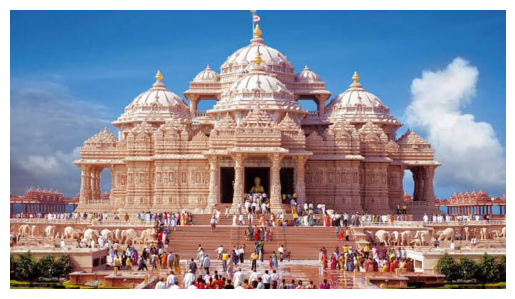

In [10]:
content_im = download_image(temple_url).to(def_device)
print('content_im.shape:', content_im.shape)
show_image(content_im);

In [11]:
content_im.min(), content_im.max()

(tensor(0.), tensor(1.))

In [13]:
class LengthDataset():
  def __init__(self, length=1): self.length = length
  def __len__(self): return self.length
  def __getitem__(self, idx): return 0,0

def get_dummy_dls(length=100):
  return DataLoaders(DataLoader(LengthDataset(length), batch_size=1),
                     DataLoader(LengthDataset(1), batch_size=1))

In [14]:
class TensorModel(nn.Module):
  def __init__(self, t):
    super().__init__()
    self.t = nn.Parameter(t.clone())
  def forward(self, x=0): return self.t

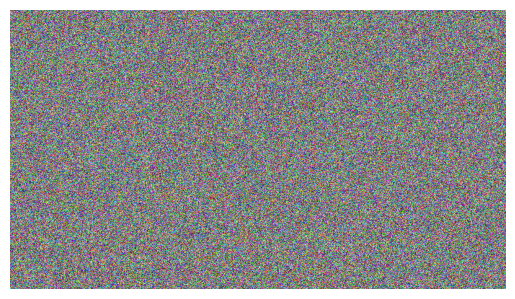

In [15]:
model = TensorModel(torch.rand_like(content_im))
show_image(model());

In [16]:
[p.shape for p in model.parameters()]

[torch.Size([3, 450, 800])]

In [18]:
class ImageOptCB(TrainCB):
  def predict(self, learn): learn.preds = learn.model()
  def get_loss(self, learn): learn.loss = learn.loss_func(learn.preds)